This notebook is an illustration of transfer learning. It uses:
- a pre-trained Model from Keras (Xception)
- a dataset of casting products, some of which have a defect
Then it adds a simple classification layer to the pre-trained model, and trains it with the pictures.

The code is adapted from: 
- Keras tutorial https://keras.io/guides/transfer_learning/
- Kaggle tutorial https://www.kaggle.com/code/digantdixit/transfer-learning-cnn-for-beginners

Works with python 12, in a `conda` env described in `environment.yml`:

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, os
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.preprocessing import image
from keras.models import Sequential

In [14]:
batch_size = 16
[train, test] = keras.utils.image_dataset_from_directory(
    directory="../casting_512x512/",
    batch_size=batch_size,
    image_size=(256, 256),
    shuffle=True,
    seed=481516342,
    validation_split=0.2,
    subset="both",
)

print(train.class_names)
print(test.class_names)

Found 1300 files belonging to 2 classes.
Using 1040 files for training.
Using 260 files for validation.
['def_front', 'ok_front']
['def_front', 'ok_front']


In [15]:
from keras.applications import Xception

xcept = Xception(input_shape=(256, 256, 3), include_top=False, weights="imagenet")

In [16]:
# Adapted code from Keras transfer learning tutorial
xcept.trainable = False
inputs = keras.Input(shape=(256, 256, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = xcept(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [17]:
print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

None


In [18]:
steps_per_epoch = len(train) // batch_size
validation_steps = len(test) // batch_size
print(steps_per_epoch, validation_steps)

model.fit(
    train,
    epochs=8,
    steps_per_epoch=steps_per_epoch,
    validation_data=test,
    validation_steps=validation_steps,
)

4 1
Epoch 1/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3542 - loss: 5.7885 - val_accuracy: 0.5000 - val_loss: 1.9043
Epoch 2/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3917 - loss: 2.3547 - val_accuracy: 0.5000 - val_loss: 1.7062
Epoch 3/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5292 - loss: 1.5945 - val_accuracy: 0.5625 - val_loss: 1.7787
Epoch 4/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6875 - loss: 1.4898 - val_accuracy: 0.5625 - val_loss: 2.2361
Epoch 5/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7563 - loss: 1.0904 - val_accuracy: 0.7500 - val_loss: 1.5913
Epoch 6/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6521 - loss: 1.2576 - val_accuracy: 0.6875 - val_loss: 1.9487
Epoch 7/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7229 - loss: 1.4770 - val_accuracy: 0.6250 - val_loss: 1.8096
Epoch 8/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6167 - loss: 1.4222 - val_accuracy: 0.5000 - val_loss: 2.7697


In [22]:
print(model.history.history.keys())

dict_keys([])


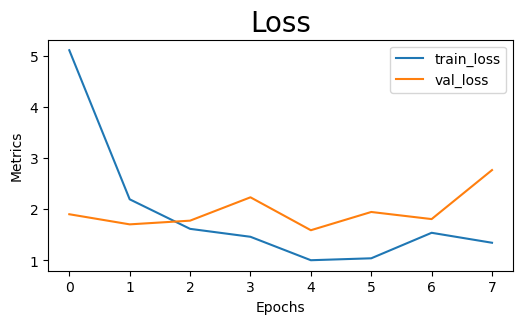

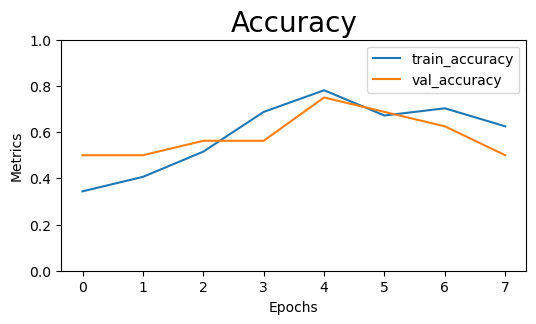

In [20]:
# plot loss
plt.subplots(figsize=(6, 3))
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("Loss", fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend(labels=["train_loss", "val_loss"])
plt.show()

# plot accuracy
plt.subplots(figsize=(6, 3))
plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history["val_accuracy"])
plt.title("Accuracy", fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.ylim(0, 1)
plt.legend(labels=["train_accuracy", "val_accuracy"])
plt.show()


Ideas of possible variations to see how performance changes:
- try using data augmentation
- try other pretrained models (resnet, mobilenet)
- try a lower number of input images 

The implementation of data augmentation, a loop on different models, and a 
summary table is left to the reader!


Alternative idea: if we don't want to use transfer learning, we can also use raw
 classifications from the pre-trained model as a proxy metric to ok/defect

In [21]:
# Incomplete code, To finish - zero-shot prediction on all images to see what comes out
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions
import numpy as np

model = Xception(input_shape=(299, 299, 3), weights="imagenet")

img_path = "../casting_512x512/ok_front/cast_ok_0_1018.jpeg"
# img_path = 'casting_512x512/def_front/cast_def_0_0.jpeg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print("Predicted:", decode_predictions(preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
Predicted: [('n03843555', 'oil_filter', 0.31126565), ('n04553703', 'washbasin', 0.22433686), ('n04019541', 'puck', 0.090620525)]
